# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

# Загрузка данных

In [2]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [3]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        self.X = X
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [4]:
x_train = FreyDataset(data[:-300])
x_val = FreyDataset(data[-300:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [5]:
batch_size = 64
train_loader = DataLoader(dataset=x_train, batch_size=batch_size, shuffle=True, num_workers=20)
val_loader = DataLoader(dataset=x_val, batch_size=batch_size, shuffle=False, num_workers=20)

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`. 

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

In [6]:
class ConvVAE(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=0, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(512, 2*latent_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu:torch.Tensor, logvar:torch.Tensor):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        latent_distribution = eps * std + mu
        return latent_distribution
 
    def forward(self, x:torch.Tensor):
        x = self.encoder(x)
        mu, logvar = x.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar

In [7]:
lr = 1e-3
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='mean')

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

В *VAE* обычно используется 2 функции потерь:
1. *Reconstruction loss*, например, *BCE loss* или *MSE loss*
2. *KL divergence loss*

Формула для последней выглядит следующим образом:
$$ \text{KL Loss}(\mu, \sigma) = -\frac{1}{2}[1 + \log(\sigma^2) -\mu^2 - \sigma^2] $$
Так как *BCE loss* мы считаем с помощью `nn.BCELoss`, осталось добавить к ней *KL divergence loss*, благодаря чему и получится `final_loss`

In [9]:
def final_loss(bce_loss, mu:torch.Tensor, logvar:torch.Tensor):
    var = torch.exp(logvar)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - var)
    return bce_loss + kl_div

## Обучение модели
Функция обучения

In [10]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(x_train)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

Функция валидации

In [11]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], reconstruction[:8]))
                save_image(both.cpu(), f"./output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

Обучаем модель

In [12]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:00, 47.29it/s]                        
5it [00:00, 87.75it/s]               

Train Loss: 0.0935
Val Loss: 0.0110
Epoch 2 of 20



27it [00:00, 80.74it/s]                        
5it [00:00, 134.33it/s]              

Train Loss: 0.0105
Val Loss: 0.0106
Epoch 3 of 20



27it [00:00, 81.47it/s]                        
5it [00:00, 125.63it/s]              

Train Loss: 0.0103
Val Loss: 0.0105
Epoch 4 of 20



27it [00:00, 81.27it/s]                        
5it [00:00, 128.38it/s]              

Train Loss: 0.0103
Val Loss: 0.0105
Epoch 5 of 20



27it [00:00, 81.09it/s]                        
5it [00:00, 107.64it/s]              

Train Loss: 0.0102
Val Loss: 0.0105
Epoch 6 of 20



27it [00:00, 81.38it/s]                        
5it [00:00, 127.62it/s]              

Train Loss: 0.0102
Val Loss: 0.0105
Epoch 7 of 20



27it [00:00, 83.62it/s]                        
5it [00:00, 128.58it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 8 of 20



27it [00:00, 83.59it/s]                        
5it [00:00, 131.08it/s]              

Train Loss: 0.0102
Val Loss: 0.0105
Epoch 9 of 20



27it [00:00, 81.17it/s]                        
5it [00:00, 130.32it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 10 of 20



27it [00:00, 83.67it/s]                        
5it [00:00, 127.73it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 11 of 20



27it [00:00, 81.59it/s]                        
5it [00:00, 129.43it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 12 of 20



27it [00:00, 84.04it/s]                        
5it [00:00, 124.66it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 13 of 20



27it [00:00, 81.36it/s]                        
5it [00:00, 132.32it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 14 of 20



27it [00:00, 82.85it/s]                        
5it [00:00, 132.18it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 15 of 20



27it [00:00, 83.01it/s]                        
5it [00:00, 128.59it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 16 of 20



27it [00:00, 82.84it/s]                        
5it [00:00, 134.36it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 17 of 20



27it [00:00, 83.74it/s]                        
5it [00:00, 139.31it/s]              

Train Loss: 0.0102
Val Loss: 0.0105
Epoch 18 of 20



27it [00:00, 84.09it/s]                        
5it [00:00, 134.76it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 19 of 20



27it [00:00, 84.97it/s]                        
5it [00:00, 130.22it/s]              

Train Loss: 0.0102
Val Loss: 0.0104
Epoch 20 of 20



27it [00:00, 83.69it/s]                        
5it [00:00, 133.87it/s]              

Train Loss: 0.0102
Val Loss: 0.0104


## Визуализация полученных изображений

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

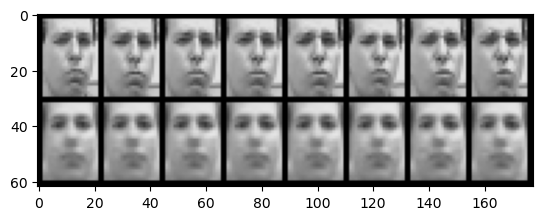

In [14]:
# 10я эпоха
image_10 = Image.open("output10.png")
plt.imshow(image_10)

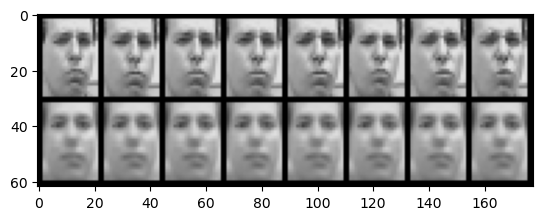

In [15]:
# 19я эпоха
image_19 = Image.open("output19.png")
plt.imshow(image_19)

Сгенерируем случайное изображение. Для этого создадим `z` - нормально распределенное латентное пространство размерности `[batch_size, channels, height, width]`, где `channels` должно быть равно `2`, т.к. мы обучали сеть именно с этим параметром. Передадим это пространство (шум) в декодер, чтобы получить результат

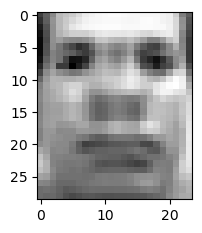

In [28]:
# Generate latent distribution z
z = torch.randn((1, 2, 15, 10)).cuda()
# Decode z
x = model.decoder(z)
image = x.cpu().detach().numpy()[0]
# Convert to uint8
image = (image * 255).astype(np.uint8)
# Display
plt.figure(figsize=(2, 3))
plt.imshow(image[0], cmap='gray')
plt.show()

Видно, что сгенерированное из случайного шума изображение имеет большое сходство с человеческим лицом, на котором мы обучали сеть